<a href="https://colab.research.google.com/github/mohsenazade/Data-Mining-Exercises/blob/main/mohsen_azadeh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Library

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
import nltk
import spacy

from nltk.corpus import sentiwordnet as swn
import re
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from collections import defaultdict



nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('sentiwordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!


True

In [ ]:
#import other lists of stopwords
with open('/content/StopWords_GenericLong.txt', 'r') as f:
 x_gl = f.readlines()
with open('/content/StopWords_Names.txt', 'r') as f:
 x_n = f.readlines()
with open('/content/StopWords_DatesandNumbers.txt', 'r') as f:
 x_d = f.readlines()
#import nltk stopwords
stopwords = nltk.corpus.stopwords.words('english')#combine all stopwords
[stopwords.append(x.rstrip()) for x in x_gl]
[stopwords.append(x.rstrip()) for x in x_n]
[stopwords.append(x.rstrip()) for x in x_d]
#change all stopwords into lowercase
stopwords_lower = [s.lower() for s in stopwords]

#DataSet

#####***Load Data***

In [ ]:
# Loading csv file
df =pd.read_csv('/content/BTCUSDnews_Azadeh_Label.csv', usecols=['Label','title','articleBody'],encoding = "ISO-8859-1")
twe=df[['Label','articleBody']]
twe['label']=twe['Label']
twe['totallText']=twe['articleBody']
totall=twe[['label','totallText']]
totall.head(3)

,label,totallText
0,0,Bitcoins price action has been incredibly lac...
1,1,"The United States is in turmoil, and the dolla..."
2,0,An over 300 million active register accounts o...


In [ ]:
totall.shape

(855, 2)

#####***Splitting into train and test***

In [ ]:
from sklearn.model_selection import train_test_split
totall_train, totall_test, target_train, target_test = train_test_split(totall.totallText,totall.label,test_size = 0.2)

In [ ]:
totall_train.shape

(684,)

In [ ]:
totall_test.shape

(171,)

In [ ]:
totall_train.head(3)

61     Despite a worsening pandemic, geopolitical tur...
249    Bitcoin risks plunging back towards $6,000 pur...
370    Bitcoin price is holding the $11,650 and $11,5...
Name: totallText, dtype: object

In [ ]:
totall_test.head(3)

149    Bitcoins extended bout of sideways trading ha...
501    At the turn of tonight&#8217;s weekly close, B...
218    Bitcoin could be an integral piece to progress...
Name: totallText, dtype: object

<Figure size 576x432 with 0 Axes>

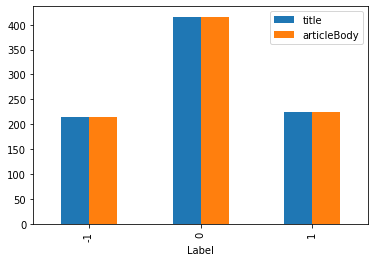

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Label').count().plot.bar(ylim=0)
plt.show()

#***Text Processing***

#####***A. Cleaning of Raw Data***

In [ ]:
def to_lower(word): 
     result = word.lower() 
     return result

In [ ]:
def remove_number(word):
    result = re.sub(r'\d+', '', word)
    return result

In [ ]:
def remove_mentions(word):       
    result = re.sub(r"@\S+", "", word)       
    return result

In [ ]:
def remove_special_characters(word):       
    result = word.translate(str.maketrans(dict.fromkeys(string.punctuation)))    
    return result

In [ ]:
def remove_stopwords(word):
    return ' '.join(word for word in i.split() if word not in stopwords_lower)


In [ ]:
def remove_whitespace(word):
    result = word.strip()
    return result


In [ ]:
def remove_punctuation(word):
    result = re.sub('[^A-Za-z]+', ' ', word)
    return result


In [ ]:
def replace_newline(word):
    return word.replace('\n','')

In [ ]:
def remove_hyperlink(word):       
    return re.sub(r"http\S+", "", word)

In [ ]:
def clean_up_pipeline(sentence):
    cleaning_data = [remove_hyperlink,
                      replace_newline,
                      to_lower,
                      remove_number,
                      remove_punctuation,
                      remove_whitespace]
    for func in cleaning_data:
        
        sentence = func(sentence)
    return sentence


In [ ]:
totall_train = totall_train.apply(clean_up_pipeline)
print(totall_train)


61     despite a worsening pandemic geopolitical turm...
249    bitcoin risks plunging back towards purely bas...
370    bitcoin price is holding the and support level...
55     markets are still reeling from the impact of t...
758    bitcoin price is only a mere few hundred dolla...
                             ...                        
792    bitcoin price traded above the resistance befo...
505    bitcoin posted a strong weekly close yesterday...
65     if the current price action is a top formation...
555    bitcoin price is down in just over hours and e...
162    bitcoin is trading in a contracting range abov...
Name: totallText, Length: 684, dtype: object


#####***B. Tokenization***

In [ ]:
from nltk.tokenize import word_tokenize
totall_train = totall_train.apply(word_tokenize)
#cleaned_tweets_test = cleaned_tweets_test.apply(word_tokenize)

In [ ]:
totall_train.head(3)

61     [despite, a, worsening, pandemic, geopolitical...
249    [bitcoin, risks, plunging, back, towards, pure...
370    [bitcoin, price, is, holding, the, and, suppor...
Name: totallText, dtype: object

#####***C. Stemming***

In [ ]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text])
totall_train = totall_train.apply(lambda text: stem_words(text))


In [ ]:
totall_train.head(3)

61     despit a worsen pandem geopolit turmoil and mo...
249    bitcoin risk plung back toward pure base on a ...
370    bitcoin price is hold the and support level ag...
Name: totallText, dtype: object

#***Word Embedding Techniques***

#####***Word2Vec***

In [ ]:
import gensim
tokenize=totall_train.apply(lambda x: x.split())
w2vec_model=gensim.models.Word2Vec(tokenize,min_count = 1, size = 100, window = 5, sg = 1)
w2vec_model.train(tokenize,total_examples= len(totall_train),epochs=20)

(513253, 740920)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
bow=CountVectorizer( min_df=2, max_features=1000)
bow.fit(totall_train)
bow_df=bow.transform(totall_train).toarray()

In [ ]:
bow_df.shape

(684, 1000)

#####***Model Fitting***

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
import numpy as np
from sklearn.svm import SVC

In [ ]:
target_train =np.array(target_train)

In [ ]:
from textblob import TextBlob

tresult = [TextBlob(i).sentiment.polarity for i in totall_train]
tpred = [0 if n < 0 else 1 for n in tresult]

#####**Performance Metrics for News Bitcoin Sentiment Analysis**

In [ ]:
vec = CountVectorizer() 

X_train_transformed =  vec.fit_transform(totall_train) 

X_test_transformed = vec.transform(totall_test)


In [ ]:
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,f1_score, precision_score,recall_score


clf= MultinomialNB()
clf.fit(X_train_transformed, target_train)

score = clf.score(X_test_transformed, target_test)
print("score of Naive Bayes algo is :\n   " , score)

y_pred = clf.predict(X_test_transformed)
cf_matrix=confusion_matrix(target_test,y_pred)
print(cf_matrix)

print(precision_score(target_test,y_pred,pos_label=1,average='macro'))
print(recall_score(target_test, y_pred, pos_label=1,average='macro') )

print("F1_Score :",f1_score(target_test, y_pred, pos_label=1,average='weighted'))



score of Naive Bayes algo is :
    0.4853801169590643
[[ 6 33  2]
 [ 4 75 10]
 [ 5 34  2]]
0.35700871898055
0.34593952681099843
F1_Score : 0.40678210678210674


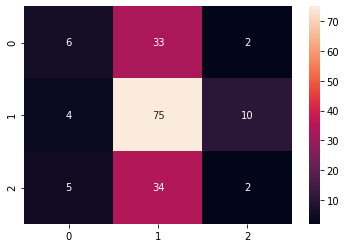

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [ ]:
from sklearn.svm import LinearSVC

In [ ]:
model = LinearSVC()
#X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train_transformed, target_train)
y_pred = model.predict(X_test_transformed)

score = model.score(X_test_transformed, target_test)
print("score of SVM is :\n   " , score)

y_pred = model.predict(X_test_transformed)
cf_matrix=confusion_matrix(target_test,y_pred)
print(cf_matrix)

print(precision_score(target_test,y_pred,pos_label=1,average='macro'))
print(recall_score(target_test, y_pred, pos_label=1,average='macro') )

print("F1_Score :",f1_score(target_test, y_pred, pos_label=1,average='weighted'))



score of SVM is :
    0.43859649122807015
[[15 14 12]
 [16 45 28]
 [ 9 17 15]]
0.41327751196172247
0.41244176486708684
F1_Score : 0.44762070017917965


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


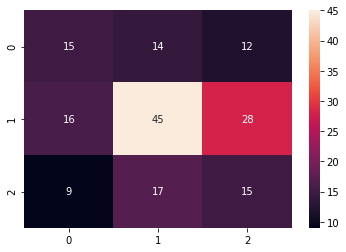

In [ ]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)